# JETSCAPE Summer School 2021: Introduction to Bayesian Inference with the simple pendulum 

## Instructor: Matthew Heffernan | McGill University

In this example notebook, we will perform Bayesian inference using a principled modeling framework. We will do this with an accessible problem, the period of a simple pendulum, so as to focus on the modeling. 

Suggested further reading:
- Michael Betancourt's [falling case study](https://betanalpha.github.io/assets/case_studies/falling.html)
- [Bayes in the Sky](https://arxiv.org/abs/0803.4089)
- [Bayesian inference in physics](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.83.943)
- Andrew Gelman's [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) textbook
- Andrew Gelman's [Bayesian Workflow](https://arxiv.org/abs/2011.01808)

Relevant JETSCAPE papers:
- [Multi-system Bayesian constraints on the transport coefficients of QCD matter](https://arxiv.org/abs/2011.01430)
- [Phenomenological constraints on the transport properties of QCD matter with data-driven model averaging](https://arxiv.org/abs/2010.03928)
- [Determining the jet transport coefficient q̂  from inclusive hadron suppression measurements using Bayesian parameter estimation](https://arxiv.org/abs/2102.11337)

This work is adapted from my recent paper, [How about that Bayes: Bayesian techniques and the simple pendulum](https://arxiv.org/abs/2104.08621).

In [1]:
# If false, use provided data points
# If true, generate new pseudo-data.
generate_data = False

# If false, uses pre-generated MCMC chains.
# If true, runs MCMC.
run_mcmc = False

## Computational Environment

In [2]:
import os
import copy

import numpy as np
import math

from scipy import special
from scipy import stats
from scipy import interpolate
import scipy.integrate as si
from scipy.optimize import fsolve

import ptemcee
import corner

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set()
%matplotlib inline

## Step 1: Picking Models

In this study, we will investigate the simple pendulum. Before any Bayesian inference can take place, a model must be defined. Critically, a statistical model must take the measurement process into account as well as the underlying process. After all, the goal is to compare apples to apples and the data we are comparing to is an inherent product of the measurement process.

### Physics of the simple pendulum

Here, we define the full and approximate equations for pendula. This was inspired by Table 11-1 in Giancoli Physics 6th ed., which claims that the small angle approximation breaks down at 15 degrees as the difference between $\theta$ and $\sin\theta$ exceeds 1%. However, is the difference actually distinguishable given the typical student's experimental precision?

We take some inspiration from [this Stackexchange question](https://physics.stackexchange.com/questions/57623/what-is-the-period-of-a-physical-pendulum-without-using-small-angle-approximatio#66469), but we turn it on its head to get a rigorous answer via statistical inference.

The period of a pendulum can be described as 
$$
I \ddot{\theta}+m g L \sin (\theta)+\frac{1}{2} \operatorname{sgn}(\dot{\theta}) L \rho_{\text {air }} C_{D} S(L \dot{\theta})^{2}+\zeta \dot{\theta}+\gamma \theta=0
$$

with $sgn()$ the signum function. To quote directly from the Stackexchange answer, the second term in this equation is the torque exerted by gravity, the third term is due to air drag (which is assumed here to only act on the bob), the fourth term is due to friction at the attachment point, and the fifth term is a linear drag effect caused by simple bending of the string (therefore, I'm assuming the pendulum was constructed with a string).

The stackexchange question considered all the terms in the above equation, where
- $I$ : mass moment of inertia of the pendulum
- $m$ : mass of the bob
- $g$ : gravitational acceleration at sea level, $9.80665 m/s^2$
- $L$ : length of the pendulum
- $\rho_{air}$ : air density at sea level ($1.225 kg/m^3$)
- $C_D$ : combined drag coefficient of the bob and string
- $S$ : frontal surface area of the bob
- $\zeta$ : damping ratio for the attachment point
- $\gamma$ : spring constant of the string as it deforms

However, we consider a simplified version by neglecting air drag, damping at the attachment point, and bending of the string.

$$
I \ddot{\theta}+m g L \sin (\theta)=0
$$

We then make the following choices:
- $I$ : mass moment of inertia of the pendulum ($mL^2$)
- $m$ : mass of the bob 

$$
mL^2 \ddot{\theta}+m g L \sin (\theta)=0
$$
$$
L^2 \ddot{\theta}+ g L \sin (\theta) = 0
$$
$$
\ddot{\theta} = - \frac{g L \sin (\theta)}{L^2}
$$
$$
\ddot{\theta} = - \frac{g\sin (\theta)}{L}
$$

For small angles,
$$
\ddot{\theta} \approx - \frac{g\theta}{L}
$$
which we immediately recognize as $F/m = -kx/m$ with $k=\frac{mg}{L}$. As the period of a simple harmonic oscillator is 
$$
T = 2\pi \sqrt{\frac{m}{k}}
$$
we recover the familiar 
$$
T = 2\pi \sqrt{\frac{L}{g}}.
$$

But what if we never take that small angle approximation? Then we need to calculate the period of the pendulum from the full expression
$$
\ddot{\theta} = - \frac{g\sin (\theta)}{L}.
$$

This is a cumbersome task. We follow the method from [this paper, American Journal of Physics 74, 892 (2006); https://doi.org/10.1119/1.2215616](https://aapt.scitation.org/doi/full/10.1119/1.2215616).

To quote,

If we take the zero of potential energy at the lowest point of the trajectory and choose for simplicity the initial conditions as $\theta(0)=+\theta_0$ and $\frac{d\theta}{dt}_0=0$, we have (from S. T. Thornton and J. B. Marion, Classical Dynamics of Particles and Systems, 5th ed. (Brooks/Cole, New York, 2004), pp. 155–158. See also Appendix B for a good discussion of elliptic integrals.)

$$
PE_0 = KE(t)+PE(t)
$$


$$
m g L\left(1-\cos \theta_{0}\right)=\frac{1}{2} m L^{2}\left(\frac{d \theta}{d t}\right)^{2}+m g L(1-\cos \theta)
$$

The solution for $\frac{d\theta}{dt}$ is then 

$$
\frac{d \theta}{d t}=\pm \sqrt{\frac{2 g}{L}\left(\cos \theta-\cos \theta_{0}\right)}
$$

If we integrate $\frac{d\theta}{dt}$ from $\theta_0$ to 0, thus choosing the − sign above, corresponding to a time equal to one-quarter of the exact period T, we have

$$
T=2 \sqrt{2} \sqrt{\frac{L}{g}} \int_{0}^{\theta_{0}} \frac{1}{\sqrt{\cos \theta-\cos \theta_{0}}} d \theta
$$

This integral is improper when $\theta=\theta_0$, but a simple substitution $\cos \theta = 1-2\sin^2(\theta/2)$ may be combined with a change of variables $\sin \phi = \frac{\sin(\theta/2)}{\sin(\theta_0/2)}$ to yield

$$
T=4\sqrt{\frac{L}{g}} \int_{0}^{\pi/2} \frac{1}{\sqrt{1-\sin^2(\theta_0/2) \sin^2(\phi/2)}} d \phi 
$$

We can then solve this elliptical integral numerically in order to calculate the result.

In this study, we fix pendulum length to be 1m as a pendulum of this size can be easily constructed at home or in common teaching laboratories and the initial angular displacement can be measured with relative precision.

### Modeling the data-gathering process

In the typical undergraduate teaching laboratory, it is recommended that the uncertainty be estimated as half of the smallest gradation of measurement of the measuring device. In this simplified case, we will not make any guesses about potential systematic errors a student may make, although this would be an interesting exercise. Note that this is a rough approximation and assumes with only 68% confidence that a student can make a measurement within half a tick on either side.

We will assume that the uncertainty is Gaussianly distributed, with $\sigma$ corresponding to half of the smallest measuring device gradation. We will assume no timing uncertainty at this stage, i.e. each datapoint is interpreted as being the result of many repeated measurements and the central limit theorem has been satisfied.

In [3]:
def T_exact(g,theta_0):
    """Period of a pendulum using the exact solution.
    
    Parameters
    ----------
    g : float
        The value of gravitational acceleration
        
    theta_0: float
        Initial angular displacement of the pendulum

    Returns
    ------
    [value,uncertainty]: list
        A list containing the predicted central value of the period as well as an uncertainty estimate
    """
    
    theta_0 = float(np.array(theta_0)) # Ensure correct type
    
    f = lambda phi: (1-np.sin(theta_0*0.5)**2*np.sin(phi*0.5)**2)**-0.5
    integral = si.quad(f,0,np.pi/2,epsabs=1e-5,epsrel=1e-5)
    
    
    intval = integral[0]
    val = 4*(1.0/g)**0.5*intval
    
    interr = integral[1]
    
    L=1.0
    L_err = 0.5e-3 # assume mm ruler, so error is half the smallest tick
    err = np.sqrt((intval/(4*(L/g)**0.5)*L_err)**2 + (val*interr)**2 )
    
    return [val,err]

In [4]:
# here's where we add our timing errors and finalize our model of a student's measurement
def model_exact(g,theta0,mu):
    """Full model of the data collection process for the exact solution.
    
    Parameters
    ----------
    g : float
        The value of gravitational acceleration
    theta0 : float
        Initial angular displacement of the pendulum
    mu : float, optional
        The value of the timing uncertainty

    Returns
    ------
    [period,uncertainty]: list
        A list containing the predicted central value of the period as well as an uncertainty estimate
    """
    if g==0 or theta0==0:
        return [0,mu]
    else:
        period, modelerr = T_exact(g,theta0)
        err = (modelerr**2+mu**2)**0.5
        return [period,err]

Now let's make a plot of the two periods to see how they diverge. We assume a pendulum length of 1m as this is a size we can expect students to have access to in labs.

### Checking model outputs

Before we begin to assign priors, we will check the model outputs to see how they behave. While in this model, this is a relatively trivial step, in more complex models performing such checks is essential in order to see if unexpected behavior arises.

In [5]:
g_earth = 9.80665 # m/s^2 at sea level
displacements = np.linspace(1e-3,np.pi/4,100) # Initial angular displacements

exact_periods = np.array([model_exact(g_earth,disp,0) for disp in displacements])


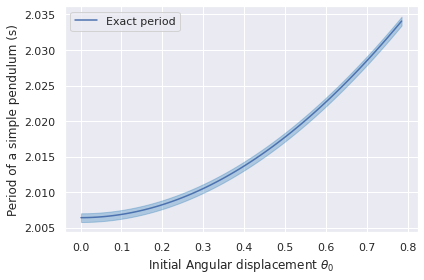

In [6]:
# Plot predictions
plt.figure()

plt.plot(displacements,exact_periods[:,0],label='Exact period')
plt.fill_between(displacements,exact_periods[:,0]-exact_periods[:,1], exact_periods[:,0]+exact_periods[:,1],
                alpha=0.3,color='tab:blue')


plt.ylabel(r'Period of a simple pendulum (s)')
plt.xlabel(r'Initial Angular displacement $\theta_0$')
plt.legend()

plt.tight_layout()

plt.savefig('Texact.png',transparent=False,dpi=600)
plt.show()

## Get some data

Ideally, we would have been in person and would have been able to take some data we measured ourselves. Instead, let's use some pseudo-data. This will require a few assumptions.

Some students are able to perform very precise measurements using smartphone accelerometers. These have an uncertainty of 0.02 s. We also assume that the experimenter is measuring 10 periods and then dividing by 10 in order to reduce the relative error of their measurement. This is standard laboratory advice for such experiments.

We use the expected error as the standard deviation of a Gaussian distribution centered on the true value.

Below, we show how we generate some pseudodata assuming the precise timing of students who used accelerometer data along with some white noise as the students likely aren't perfect. 

Some pre-generated data is already included with this exercise.

In [9]:
error_accelerometer = ((0.02**2+0.02**2)**0.5) # accelerometer timing uncertainty in seconds

if generate_data: # Generate new data

    # Choose some arbitrary angles.
    measured_displacements = [0.01, 0.2, 0.4, 0.5, np.pi/4] 

    # Calculate periods
    data_accelerometer = [model_exact(g_earth,disp,error_accelerometer/10)  \
                    for disp in measured_displacements]

    # Add some white noise to the data to make it a little more realistic
    accelerometer_means = [dat[0]+stats.norm(0,0.002).rvs() for dat in data_accelerometer] 
    accelerometer_errs = [dat[1] for dat in data_accelerometer]
    
    # Save to file
    data_df = pd.DataFrame(np.array([measured_displacements,
                       accelerometer_means,
                       accelerometer_errs]).T, columns=['angle','period','uncertainty'])
    
    data_df.to_csv('Data.csv')
    
    # Put variable in a convenient format for later
    measured_theta = [[measured_displacements[i]] for i in range(len(data_accelerometer))]
    
else: # Read pre-generated data
    
    if not os.path.exists('Data.csv'):
        print('Pre-generated data not found')
    else:
        # Read DataFrame
        data_df = pd.read_csv('Data.csv',header=0,index_col=0)

        # Assign columns to variables with the proper type
        measured_displacements = list(data_df['angle'])
        accelerometer_means = list(data_df['period'])
        accelerometer_errs = list(data_df['uncertainty'])

        # Put in a convenient format for later
        measured_theta = [[measured_displacements[i]] for i in range(len(measured_displacements))]


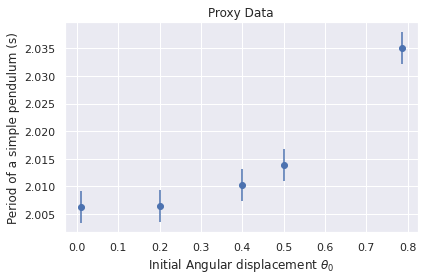

In [10]:
plt.figure()
plt.errorbar(measured_theta,accelerometer_means,
             yerr=accelerometer_errs,fmt='o')

plt.title(r'Proxy Data')
plt.ylabel(r'Period of a simple pendulum (s)')
plt.xlabel(r'Initial Angular displacement $\theta_0$')
plt.tight_layout()
plt.savefig('accelerometer-proxydata.png',transparent=False,dpi=600)

plt.show()

### Physics Models: Exercises

1. If we include more data points, will we necessarily get better constraints?
2. Since we are modeling this data, is it reasonable to expect better data than this or worse in the lab?
3. If you are feeling ambitious, vary the number of measurements made and re-run the inference. What happened to your constraints?

## Bayesian inference: How much can we constrain g with these measurements?

Now that we have established the physics model and have generated pseudo-data, we can start to consider Bayesian techniques.

First, we visualized the data and realize that a dependence on initial angular displacement $\theta_0$ is measurable with precise timing. We proceed with a demonstration of Bayesian methods in order to see how much we can constrain $g$ while following a rigorous modeling workflow.

Let us now pretend that we are blind to how our data was generated. Ideally, we would use real world data from a class or through a group exercise, but we don't happen to have access to any that includes angular displacement for now.

What we immediately see is a relationship between the observed periods and angular displacement. It isn't clear from this data what the exact relationship is, but we've already established the models we will be considering.

In the accelerometer data, we see nonlinear behavior. If we had larger uncertainties, it would be less clear if the trend was linear on nonlinear. Interesting! This is a decent lesson for anyone asking why it matters to put more effort into making better measurements.

We already constructed our model in our Physics section above. Let's recap the highlights.

The expression for the period of a pendulum assuming small angle displacement is
$$
T = 2\pi \sqrt{\frac{L}{g}}.
$$

If we relax this assumption, the period of a pendulum can be described as 
$$
T=4\sqrt{\frac{L}{g}} \int_{0}^{\pi/2} \frac{1}{\sqrt{1-\sin^2(\theta_0/2) \sin^2(\phi/2)}} d \phi 
$$

where $\theta_0$ is our initial displacement.

In theory, we could construct a small angle model as well and perform Bayesian model selection, but this is too much material for this session. Instead, we will simply calibrate our model to data and will then see how much constraint we can achieve.

### Step 2: Defining principled priors

We only have one free parameter in our models: the gravitational acceleration, $g$. 

We have relatively little *a priori* knowledge of what we should expect as a value for gravitational acceleration. Most studies such as falling ball examples focus on order of magnitude estimates. However, it is also possible to ascribe some degree of physical intuition to the problem. We do know *a priori* that gravitational acceleration on the surface of a body scales with the mass of the body. We know that [gravitational acceleration on the moon](https://www.sciencedirect.com/science/article/pii/S0012821X12000969) is approximately 1.625 $m/s^2$ and the [surface gravity of Jupiter](https://solarsystem.nasa.gov/planets/jupiter/by-the-numbers/) is 24.79 $m/s^2$. We can be relatively confident that the moon is less massive than the Earth since the Earth-moon system is tidally locked and the moon orbits the earth. From estimates going back to Laplace, we can also be confident that Jupiter is more massive than the earth. We allow for some probability of surprise, but are sufficiently confident that we allow only 1% of the prior probability to fall outside the range \[1.625, 24.79\] $m/s^2$. We use an inverse-gamma distribution as a weakly-informative prior to encode this information as it ensures that $g$ is positive definite, which we also know, but has no known upper bound.

$$
1.625 m/s^2 \leq g \leq 24.79 m/s^2
$$

This is an attempt to define a weakly informative prior that incorporates physical constraints. The idea behind weakly informative priors is that the main constraint on the posterior should come from the likelihood, not the prior. This is thus a broad prior compared to the expected constraint from the likelihood. 

For more on priors, check out the [Stan prior choice recommendations.](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations.)


Let's now tune the inverse gamma distribution to have the properties we want. We do this using a root solving algorithm.

In [11]:
# Use minimization to tune the parameters of the distribution

tune_invgamma = lambda x,a: stats.invgamma.interval(0.9900, a,loc=x,scale=20)

def tune(x):
    (a,b)=tune_invgamma(x[0],x[1])
    return[a-1.625,b-24.79]

root=fsolve(tune,[10,.5])

Looking good! Let's now plot the pdf to see what we're working with more intuitively.

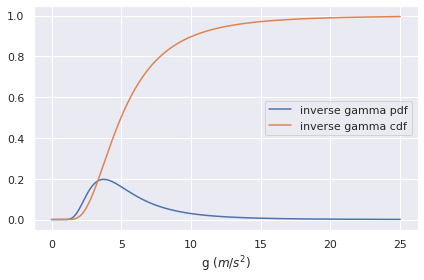

In [12]:
# Plot the prior PDF and CDF to see if it meets our constraints

g=np.linspace(0,25,1000)

plt.figure()
plt.plot(g, stats.invgamma.pdf(g, root[1],scale=20), label='inverse gamma pdf')
plt.plot(g, stats.invgamma.cdf(g, root[1],scale=20), label='inverse gamma cdf')

plt.legend()
plt.xlabel(r'g $(m/s^2)$')
plt.tight_layout()
plt.savefig('g-prior-wcdf.png',transparent=False,dpi=600)
plt.show()


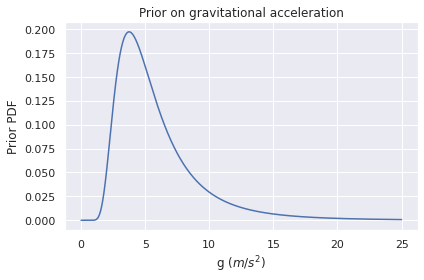

In [13]:
# Plot just the prior pdf

prior_g = stats.invgamma(root[1],scale=20)

plt.figure()

plt.plot(g,prior_g.pdf(g))

plt.xlabel(r'g ($m/s^2$)')
plt.ylabel('Prior PDF')
plt.title('Prior on gravitational acceleration')
plt.grid(True)
plt.tight_layout()

plt.savefig('g-prior.png',transparent=False,dpi=600)
plt.show()


We will define an additional distribution for our initial angle of displacement just so we can draw samples from it to see what impact this may have on the period. Since no angles are necessarily more likely and we are not ascribing any physical meaning to this and we also know that after about 90 degrees, we're likely to have other effects come in and the string won't remain taut. As a result, we draw potential values from a uniform distribution, $U(0,\pi/2)$.

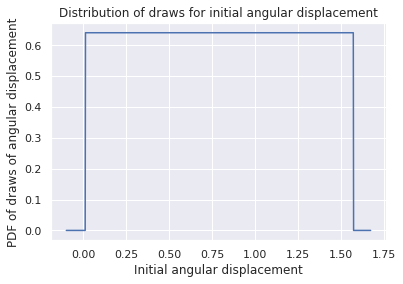

In [14]:
# Choose a distribution from which to sample initial angular displacement. 

dist_theta0=stats.uniform(loc=1e-2,scale=np.pi/2-1e-2)
dist_range_theta = np.linspace(-0.1,np.pi/2+0.1,1000)

plt.figure()

plt.plot(dist_range_theta,dist_theta0.pdf(dist_range_theta))

plt.xlabel('Initial angular displacement')
plt.ylabel('PDF of draws of angular displacement')
plt.title('Distribution of draws for initial angular displacement')
plt.grid(True)

plt.show()

### **Principled Priors: Exercises** 
1. Motivate a different prior choice for g and plot it. The [SciPy.stats reference](https://docs.scipy.org/doc/scipy/reference/stats.html) may be useful. Do you expect it to be more or less informative than the given choice?
2. Implement your different prior choice and observe the difference in the prior predictive distributions and inference below. Does it make a difference in the result? Be careful to not just put in the known value as the prior!

### Step 3: Prior Predictive Checks

Now we perform a check to make sure that our priors aren't in conflict with domain expertise. For example, we know that the result for the period of a pendulum shouldn't be absurdly short or absurdly long (not microseconds, not minutes). Let's generate an ensemble of samples from our priors and calculate the periods.

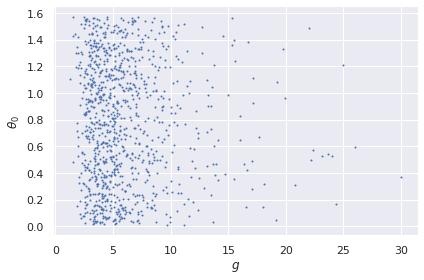

In [15]:
# Generate and plot samples from g, theta.

ndraws=1000

prior_draws_g=prior_g.rvs(size=ndraws)

draws_theta0=dist_theta0.rvs(size=ndraws)

prior_points=[[prior_draws_g],[draws_theta0]]

plt.figure()

plt.scatter(prior_points[0],prior_points[1],s=1)

plt.xlabel(r'$g$')
plt.ylabel(r'$\theta_0$')
plt.tight_layout()

plt.savefig('joint-prior.png',transparent=False,dpi=600)
plt.show()


**Exercise**: Comment on the distribution of points. Do they fall mostly in the region we care about most? Do they broadly represent our expercations or have we mis-specified a prior?

In [16]:
# Draw samples from the prior
prior_draws = [[prior_draws_g[i],draws_theta0[i]] for i in range(len(prior_draws_g))]

In [17]:
# Perform model calculations at prior samples
prior_predictive_exact = np.array([model_exact(draw[0],draw[1],0) for draw in prior_draws])

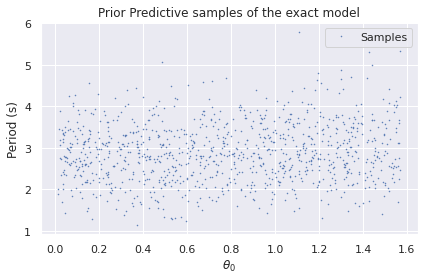

In [18]:
plt.figure()

plt.errorbar([row[1] for row in prior_draws],prior_predictive_exact[:,0],
             fmt='.',ms=1,label='Samples')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'Period (s)')
plt.title(r'Prior Predictive samples of the exact model')
plt.legend()
plt.tight_layout()
plt.savefig('prior-predictive-exact.png',transparent=False,dpi=600)
plt.show()

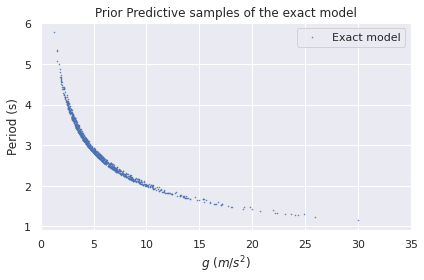

In [19]:
# Exercise: Plot the prior predictive samples of the period vs. g 

plt.figure()

plt.scatter([row[0] for row in prior_draws],prior_predictive_exact[:,0],marker='.',s=1,label='Exact model')

plt.xlabel(r'$g$ $(m/s^2)$')
plt.ylabel(r'Period (s)')
plt.title(r'Prior Predictive samples of the exact model')
plt.legend()
plt.xlim(0,35)
plt.tight_layout()
plt.savefig('prior-predictive-g.png',transparent=False,dpi=600)
plt.show()

**Exercise**: Does it look like our samples cover the range of periods we expect well? Given our data above, do you expect we will be able to achieve good constraint? Why or why not?

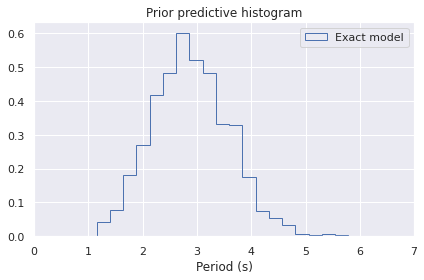

In [20]:
# Plot the histogram of the prior predictive vs. the period

plt.figure()

plt.hist(prior_predictive_exact[:,0],bins=int(2*(ndraws**(1/3))),density=True,
         fill=False,histtype='step',label='Exact model')

plt.xlabel(r'Period (s)')
plt.title(r'Prior predictive histogram')
plt.legend(loc=1)
plt.xlim(0,7)
plt.tight_layout()
plt.savefig('prior-predictive-g-hist.png',transparent=False,dpi=600)
plt.show()

**Exercise**: At this point, stop for a sanity check. Does this distribution seem in line with expectations? Should we have a reasonable expectation that the prior is outside the range we show here? If so, it is time to modify our priors.

We see that our model works as we anticipate, it takes random samples of our parameters and returns a wide range of periods, all of which are basically reasonable given our inputs. We see both models have decent coverage of the space. But we can do better than just prior samples, we can plot contours.

In [21]:
prior_predictive_ex = pd.DataFrame(np.array([[row[0] for row in prior_draws],
                                             [row[1] for row in prior_draws],
                                             prior_predictive_exact[:,0],
                                             prior_predictive_exact[:,1]]).T,
                                   columns=["g","theta_0","T","T_err"])

We'll use kernel density estimators, but this has a problem around the edges that can clearly be seen when we plot the histogram directly. Recall we used a uniform prior for $\theta_0$, so we need to remember this when interpreting these plots.

We can make these a little more informative using very Bayesian-style joint plots.

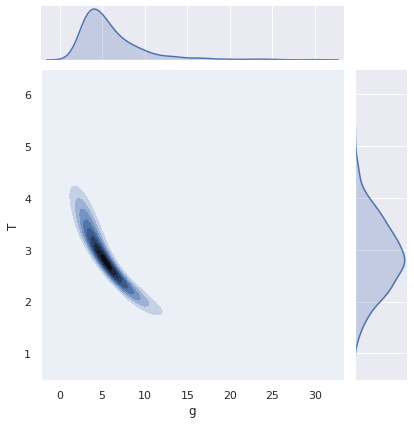

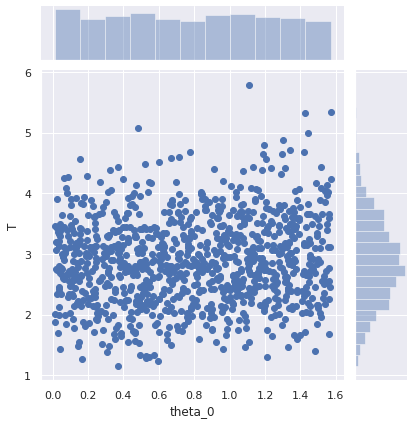

In [22]:
sns.jointplot(
    data=prior_predictive_ex,
    x="g", y="T",
    kind="kde"
)
sns.jointplot(
    data=prior_predictive_ex,
    x="theta_0", y="T",
)

plt.show()

Notice that we don't use kernel density estimation (KDE) for our plot with $\theta_0$. KDE won't resolve the sharp edges of the uniform prior well and will mislead us into thinking we have smooth cutoffs when we have sharp cutoffs.

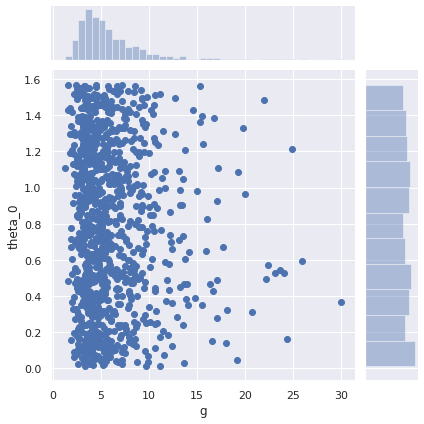

In [23]:
sns.jointplot(
    data=prior_predictive_ex,
    x="g", y="theta_0")
plt.show()


We see that $\theta_0$ is being sampled as expected, we get to see very nice recovery of our prior distributions in the marginal historgrams, and we can see the joint regions being probed between the parameters.

Great, we see that it all works as we anticipated it would.

### Step 3: Model Validation via Closure Tests (or: Empirical Coverage tests)

We should perform closure tests on our model before comparing to data. This establishes a "best case" scenario for our inference and sets an expectation for what a productive fit looks like and what kind of constraint we can actually get and what covariances may exist in our model. This is also an opportunity to determine if the prior is overly-informative. The goal is to determine if we are able to recover what we put in: if we can't, then we need to re-examine our models or the viability of the study.

In these tests, we generate some new pseudo-data using the surface gravity of Mars, a planet with approximately similar mass that should be compatible with our priors.

This is also an important opportunity to check all of the machinery of Bayesian inference in a controlled way. We will first generate new pseudo-data and then use our MCMC to evaluate the posterior. We will also perform checks on our MCMC to ensure it has the desired properties. Once we have validate the machinery here, simply changing the data we calibrate to will allow us to perform our full study.

In [24]:
error_closure = 0.05 # set the precision of the timing
g_mars = 3.72076 # m/s^2, the gravity due to acceleration on Mars

closure_displacements = [0.05, 0.2, 0.35, 0.4, np.pi/5]

closure_data_ex = [model_exact(g_mars,disp,error_closure/10) for disp in closure_displacements]

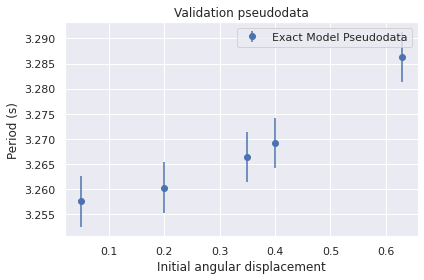

In [25]:
closure_theta = [[closure_displacements[i]] for i in range(len(closure_data_ex))]

closure_means_ex = [dat[0] for dat in closure_data_ex]
closure_stds_ex = [dat[1] for dat in closure_data_ex]

plt.figure()

plt.errorbar(closure_theta,closure_means_ex,yerr=closure_stds_ex,fmt='o',label='Exact Model Pseudodata')

plt.xlabel(r"Initial angular displacement")
plt.ylabel(r"Period (s)")
plt.title(r"Validation pseudodata")
plt.legend()
plt.tight_layout()
plt.savefig('validation-data.png',transparent=False,dpi=600)

plt.show()

The first thing we should do is make a quick visual check and ask if the validation data looks like our real data - does it have similar features? 

Clearly in our case the answer is yes, but if we were comparing multiple models, or if we had true data to compare to, the answer may not be as clear. If we see extra or missing features in our closure data, we may not get the information we may want to consider modifying our models.

#### Step 3.1 Model Validation: Markov Chain Monte Carlo

Let's now do our MCMC sampling.

One might think we should treat initial displacement $\theta_0$ as a parameter. But we recognize that it's also the dependent variable of our simulation and we know explicitly at which $\theta_0$ the data is measured. This means that it's no longer a free parameter of the model and we should treat it appropriately.

In [26]:
# write a model wrapper so that the measured values of theta0 are passed to the models 
# and constructed into a list

def model_ex_thetalist(g,thetas,mu):
    return [model_exact(g,theta,mu) for theta in thetas]

We've defined our priors explicitly earlier, but let's go ahead and define functions for our log priors, our log likelihood, and our log posterior.

We construct the likelihood by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~H) = \prod_{i=1}^M p(x_i~|~H)$$

but in practice, we use the log likelihood.

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^M \left[ \log(2\pi  \sigma^2) + \frac{(X_i - X_{\rm Model})^2}{\sigma^2} \right]$$

where $i$ denotes summation over each data point. In our implementation, $\sigma^2$ is the total variance, $\sigma_{Data}^2 + \sigma_{Model}^2$.

In [27]:
# The documentation for the ptemcee package can leave something to be desired. 
# Here are some docstrings as a reference.

ptemcee_sampler_docstring = """
ptemcee.Sampler(
    nwalkers,
    dim,
    logl,
    logp,
    ntemps=None,
    Tmax=None,
    betas=None,
    threads=1,
    pool=None,
    a=2.0,
    loglargs=[],
    logpargs=[],
    loglkwargs={},
    logpkwargs={},
    adaptation_lag=10000,
    adaptation_time=100,
    random=None,
)
"""
sampler_sample_docstring = """
sampler.sample(
    p0=None,
    iterations=1,
    thin=1,
    storechain=True,
    adapt=False,
    swap_ratios=False,
)
"""

In [28]:
def log_prior(theta):
    """Calculates the log prior for the parameter vector theta
    
    Parameters
    ----------
    theta : array
        The parameter vector. In the simple pendulum example, this is simple np.array([g])
        
    Returns
    ------
    logprior: float
        The prior probability of this choice of parameter vector
    """
    
    try:
        logprior = np.log(prior_g.pdf(theta)) 
        return logprior
    
    except ValueError:
        return -np.inf

# We already defined the log prior, so do not need to do so again.
    
def log_likelihood_ex(theta, thetalist, Xmeans, Xerrs,mu): 
    """Log likelihood for data X given parameter array theta and the exact expression for the period.
    
    Parameters
    ----------
    theta : array
        The parameter vector.
    thetalist : list
        List of initial angular displacements of the pendulum
    Xmeans : array
        Array of central values of the data
    Xerrs : array
        Array of data uncertainties
    mu : float
        The value of the timing uncertainty incorporated into the model calculation. Typically 0.

    Returns
    ------
    likelihood : float
        The likelihood | the data and model
    """
    
    if theta < 0:
        return -np.inf
    
    model = np.array(model_ex_thetalist(theta,thetalist, mu))
    
    X_model = model[:,0]
    X_modelerr = model[:,1]

    try:
        likelihood=-0.5 * np.sum(np.array([(a-c)**2/(b**2+d**2) for (a,b,c,d) in zip(Xmeans, Xerrs,
                                                                                     X_model, X_modelerr)])) \
            - 0.5*sum([np.log(2*np.pi*(err_dat**2+err_model**2)) for (err_dat,err_model) in zip(Xerrs,X_modelerr)])   

        if math.isnan(likelihood):
            likelihood=-np.inf
        else:
            return likelihood
    
    except ValueError:
        return -np.inf

def log_posterior_ex(theta, thetalist, Xmeans, Xerrs,mu):
    """Log posterior for data X given parameter array theta and the exact expression for the period.
    
    Parameters
    ----------
    theta : array
        The parameter vector.
    thetalist : list
        List of initial angular displacements of the pendulum
    Xmeans : array
        Array of central values of the data
    Xerrs : array
        Array of data uncertainties
    mu : float
        The value of the timing uncertainty incorporated into the model calculation. Typically 0.

    Returns
    ------
    post : float
        The posterior | the data, model, and priors
    """
    
    try:
        post = log_prior(theta) + log_likelihood_ex(theta, thetalist, Xmeans, Xerrs,mu)
        if math.isnan(post):
            return -np.inf
        else:
            return post
    
    except ValueError:
        return -np.inf

In [29]:
# Here we actually perform the MCMC Sampling

# 1. Define the parameters
ntemps=25
Tmax = 1e3

nwalkers = 10 # Typically 10*ndim
ndim = 1
nburnin = 1000 # The number of steps it takes for the walkers to thermalize
niterations= 5000 # The number of samples to draw once thermalized
nthin = 1 # Record every nthin-th iteration

nthreads = 4 # Easy parallelization! 

min_theta = [1.625] # Lower bound for initializing walkers
max_theta = [24.79] # Upper bound for initializing walkers

if run_mcmc:

    # 2. Instantiate the sampler object with the parameters, data, likelihood, and prior.
    ptsampler_ex=ptemcee.Sampler(nwalkers, ndim, log_likelihood_ex, log_prior, ntemps, 
                      threads=nthreads, Tmax=Tmax, loglargs=[closure_displacements, closure_means_ex, closure_stds_ex,0])

    # 3. Initialize the walkers at random positions in our 99% prior range
    pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

    # 4. Run the sampler's burn-in iterations
    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_ex.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_ex.reset() # Discard previous samples from the chain, but keep the position

    print("Running MCMC chains")
    # 5. Now we sample for nwalkers*niterations, recording every nthin-th sample
    for p, lnprob, lnlike in ptsampler_ex.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_ex.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    # We only analyze the zero temperature MCMC samples
    
    np.save('closure_ex_chain_user', ptsampler_ex.chain[0, :, :, :])
    closure_ex_chain = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    
else: # Load pre-generated chain
    
    # The pre-generated chain included with this example was generated by the above code.
    closure_ex_chain = np.load('closure_ex_chain.npy').reshape((-1,ndim))

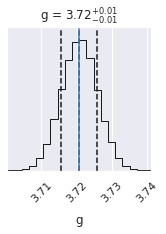

In [30]:
# Make a corner plot with the posterior distribution
fig = corner.corner(closure_ex_chain, labels=["g"],
                    truths=[g_mars], quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

Gravity on Mars is 3.72076 $m/s^2$! When compared to data generated by the model, we can clearly constrain the data successfully.

One way to think about this is as follows: "If our model is exactly true, what should we expect?" This obviously represents a best-case scenario.

This is thus exactly in line with our expectations.

Let's now look at the trace to get an idea of how our chain and the posterior is behaving.

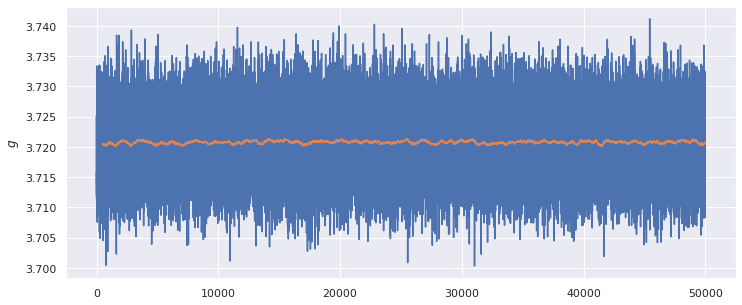

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df_validation_chain_ex = pd.DataFrame(closure_ex_chain,columns=['g'])
df_validation_chain_ex['ma_g'] = df_validation_chain_ex.g.rolling(window=500,center=False).mean()

ax.plot(np.arange(closure_ex_chain.shape[0]),closure_ex_chain[:,0],label=r'$g$')
ax.plot(np.arange(closure_ex_chain.shape[0]),df_validation_chain_ex['ma_g'],label=r'Moving average')
ax.set_ylabel(r'$g$')

plt.show()

The MCMC behavior is very good. The rolling average is stable, there are no coordinated walks, and the chain is clearly exploring the space while returning to the region of high posterior density.

If you do see the rolling average moving in a certain direction, a general trend in your MCMC, or a sudden change in the chain (particularly if it is close to the end) **the MCMC has not converged to the target distribution**. In this case, run a longer burn-in or consider what may be behind this, any results derived from a MCMC chain not in equilibrium with the target distribution **can not be trusted**.

In [32]:
def autocorrelation(chain, max_lag=100):
    """Calculates autocorrelation in an MCMC chain with a given lag
    
    This quantifies how correlated neighboring steps are. No autocorrelation
    corresponds to independent true samples of the target distribution.
    
    Autocorrelation is the inner product of the unshifted chain
    
    Parameters
    ----------
    chain : array
        MCMC Samples
    max_lag : float, optional
        Maximum lag to extend to. Default 100.

    Returns
    ------
    acors : array
        Autocorrelations with lag corresponding to the index
    """
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted,unshifted))
        normalization *= np.sqrt(np.dot(shifted,shifted))

        acors[lag] = np.dot(unshifted,shifted)/ normalization
    return acors

In [33]:
acors_ex_closure = autocorrelation(closure_ex_chain.flatten(),max_lag=25)

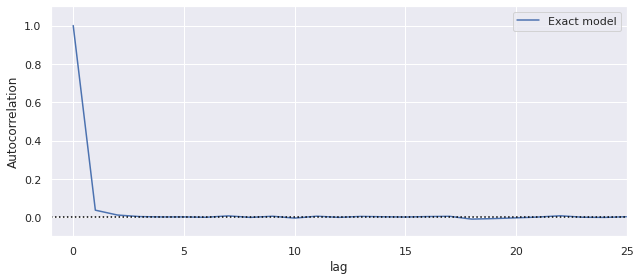

In [34]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(acors_ex_closure,label="Exact model");
plt.axhline(y=0, color="black", linestyle=":")
ax.set(xlabel='lag', ylabel='Autocorrelation', ylim=(-.1, 1.));
plt.legend()
plt.xlim(-1,25)
plt.ylim(-0.1,1.1)
plt.tight_layout()
plt.savefig('autocors_closure.pdf',transparent=False,dpi=600)
plt.show()



The autocorrelation begins at 1 (a sample is identical to itself) and then immediately drops to fluctuate around 0. This demonstrates that individual draws are uncorrelated and we are drawing samples from the target distribution - the posterior.

Other diagnostics exist, such as the [Gelman Rubin diagnostic](https://github.com/furnstahl/Physics-8805/blob/master/topics/mcmc-sampling/MCMC-diagnostics.ipynb). This can show us if we need longer MCMC chains.

**Optional exercise**: From the link above, implement the Gelman Rubin diagnostic for these chains. Should they be longer?

#### Step 3.2: Model Validation Posterior Predictive Checks

Now we want to visualize the difference between prior draws at measured values and posterior draws. We will do this by generating a representative number of samples from the prior and a reperesentative set of samples from our MCMC samples and plotting them over the data to see the impact of our calibration.

In [35]:
ndraws=5000

# Draw from the prior and calculate periods

# Draw
prior_draws_g=prior_g.rvs(size=ndraws)
prior_draws_closure = [[prior_draws_g[i],0] for i in range(len(prior_draws_g))]

# Calculate
prior_predictive_exact = np.array([model_ex_thetalist(draw[0],closure_displacements,0) \
                                   for draw in prior_draws_closure])

# Format for convenient plotting
periods_prior_ex = [[group[i][0] for i in range(len(group))] \
                    for group in prior_predictive_exact]
angles_prior_ex = [[closure_displacements[i]for i in range(len(group))] \
                   for group in prior_predictive_exact]


In [36]:
# Draw the last 1000 samples from the MCMC chain and calculate periods

# Draw
posterior_draws_ex_g = df_validation_chain_ex['g'][::1000].values


# Calculate
posterior_predictive_exact = [model_ex_thetalist(posterior_draws_ex_g[i],
                                                 closure_displacements,0) \
                              for i in range(len(posterior_draws_ex_g))]

# Format for convenient plotting
periods_post_ex = [[group[i][0] for i in range(len(group))] for group in posterior_predictive_exact]
angles_post_ex = [[closure_displacements[i] for i in range(len(group))] \
                  for group in posterior_predictive_exact]

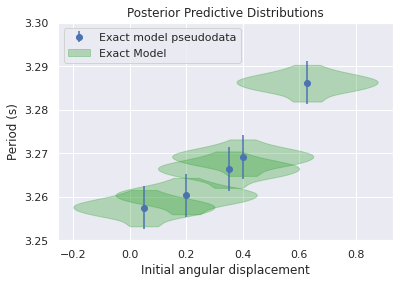

In [37]:
# Make violin plots to visualize distributions at each point

plt.figure(1)

pseudodata = plt.errorbar(closure_theta,closure_means_ex,yerr=closure_stds_ex,label='Exact model pseudodata',fmt='o')
violinex = plt.violinplot([np.array(periods_post_ex)[:,i] for i in range(len(closure_theta))],np.array(closure_theta),showmeans=False, showextrema=False, showmedians=False)
    
for pc in violinex['bodies']:
    pc.set_facecolor('tab:green')
    pc.set_edgecolor('tab:green')

post_patch = mpatches.Patch(color='tab:green', alpha=0.3, label='Exact Model')

plt.xlabel(r"Initial angular displacement")
plt.ylabel(r"Period (s)")
plt.title(r"Posterior Predictive Distributions")
plt.legend(handles=[pseudodata,post_patch],loc=2)

plt.ylim(3.25,3.3)
plt.savefig('closure_predictives.png',dpi=600)

plt.show()

In [38]:
nsamples = len(df_validation_chain_ex['g'])
n_of_bins = int(2*nsamples**(1/3))

bins_mincex = 3.69
bins_maxcex = 3.75

binscex = np.linspace(bins_mincex,bins_maxcex,n_of_bins)
dbinscex = np.abs(binscex[1]-binscex[0])

percentilescex = np.percentile(df_validation_chain_ex['g'], [16, 50, 84])

central_valueex = round(percentilescex[1],4)
lowerrex = round(percentilescex[0]-percentilescex[1],4)
higherrex = round(percentilescex[2]-percentilescex[1],4)

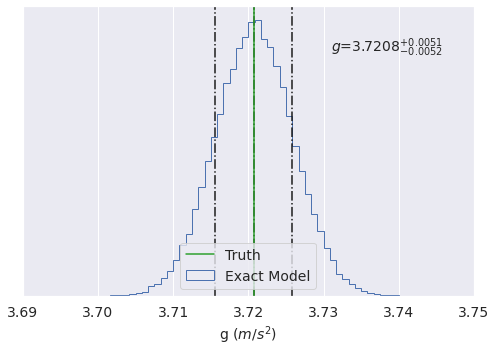

In [39]:
plt.figure(figsize=(7,5))
plt.hist(df_validation_chain_ex['g'],bins=binscex,density=True,histtype='step',label='Exact Model')
    
for i in range(len(percentilescex)):
    plt.axvline(percentilescex[i],color='k',linestyle='-.')
    
plt.axvline(g_mars,color='tab:green',linestyle='-',label='Truth')

plt.text(3.731,70,r'$g$=$'+str(central_valueex)+'^{+'+str(higherrex)+'}_{'+str(lowerrex)+'}$',size=14)

plt.xlim(3.69,3.75)
plt.xlabel(r'g ($m/s^2$)',fontsize=14)
plt.yticks([])
plt.legend(loc=8,fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.savefig('closure_combo_cornerplot.png')
plt.show()

**Exercise**: What can you conclude from the violin plots and the histogram? What does this tell us about the model's ability to reproduce data? Should this tell us about what to expect from the full inference with data?

What we very happily see here is that our inference has worked! We see that the prior predictive samples covered the space well (especially if one extends the y range of the plots) and that after Bayesian inference, the posterior predictive samples are very close to the validation pseudodata. 

We also notice that at the lower gravities on Mars, we achieve good resolution on the parameters and the peak of the distribution is very close to the true value. The uncertainties are also quite small in the 68% credible region. This suggests quite strongly that when calibrating to data, we can expect good constraint.


### Step 4: Fitting the Model  - Inference with Data

Now that we are confident in our model, confident in our inference, and have explored and inspected everything we could think of, we can finally begin to work with real data. 

Let's do our calibration with proxy data from a student on Earth.

In [40]:
ntemps=25
Tmax = 1e3

nwalkers = 10
ndim = 1
nburnin = 1000
niterations= 5000
nthin = 1 # only record every nthin iteration

nthreads = 4

min_theta = [1.625]
max_theta = [24.79]

if run_mcmc:
    ptsampler_exinf=ptemcee.Sampler(nwalkers, ndim, log_likelihood_ex, log_prior, ntemps, 
                      threads=nthreads, Tmax=Tmax, loglargs=[measured_theta, accelerometer_means, accelerometer_errs,0])


    # Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
    # argument to PTSampler. 

    # First, we run the sampler for 1000 burn-in iterations:
    pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_exinf.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_exinf.reset()

    print("Running MCMC chains")
    #Now we sample for nwalkers*niterations, recording every nthin-th sample:
    for p, lnprob, lnlike in ptsampler_exinf.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_exinf.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    # We only analyze the zero temperature MCMC samples
    np.save('inference_ex_chain', ptsampler_exinf.chain[0, :, :, :])
    inference_ex_chain = ptsampler_exinf.chain[0, :, :, :].reshape((-1, ndim))

else: # Load a pre-generated chain
    # The pre-generated chain included with this example was generated by the above code.
    inference_ex_chain = np.load('inference_ex_chain.npy').reshape((-1,ndim))

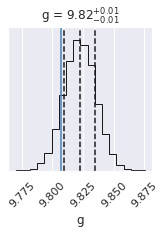

In [41]:
# Make a corner plot with the posterior distribution
fig = corner.corner(inference_ex_chain, labels=["g"],
                    truths=[g_earth], quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.savefig('inference_ex_cornerplot.png',dpi=600)

Let's now see what we observe: we nearly achieve closure on $g$ and have really good precision on the inference. This is thus exactly in line with our expectations, but it looks like there's a feature in the data that isn't accounted for in the model causing it to be biased toward larger values of $g$. This suggests that the model can be improved by making it more robust to outliers or by incorporating a more sophisticated model of the measurement process.

We happily note as well that this broadly matches our expectations from the closure tests.

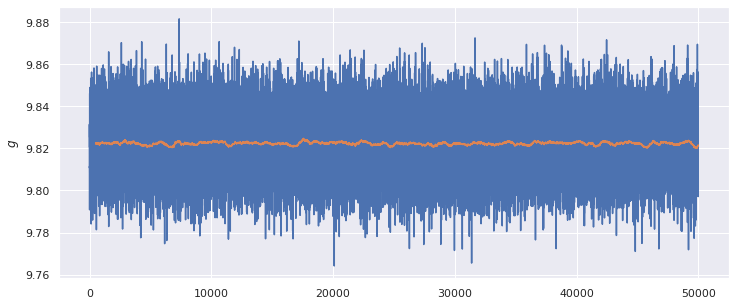

In [42]:
fix, ax = plt.subplots(1,1,figsize=(12,5))
df_chain_pex = pd.DataFrame(inference_ex_chain,columns=['g'])
df_chain_pex['ma_g'] = df_chain_pex.g.rolling(window=500,center=False).mean()

ax.plot(np.arange(inference_ex_chain.shape[0]),inference_ex_chain[:,0],label=r'$g$')
ax.plot(np.arange(inference_ex_chain.shape[0]),df_chain_pex['ma_g'],label=r'Moving average')
ax.set_ylabel(r'$g$')

plt.savefig('inference_ex_tracemeans.png',dpi=600)

plt.show()

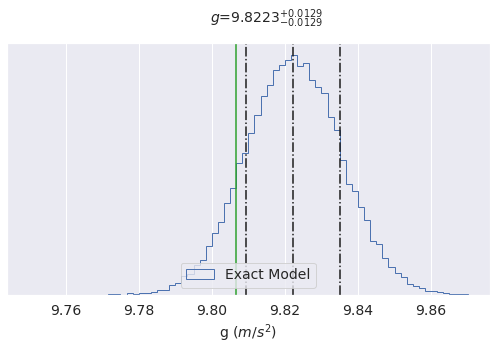

In [43]:
nsamples = len(df_chain_pex['g'])
n_of_bins = int(2*nsamples**(1/3))

bins_minex = 9.75
bins_maxex = 9.87
binsex = np.linspace(bins_minex,bins_maxex,n_of_bins)
dbinsex = np.abs(binsex[1]-binsex[0])

percentilesex = np.percentile(df_chain_pex['g'], [16, 50, 84])

central_valueex = round(percentilesex[1],4)
lowerrex = round(percentilesex[0]-percentilesex[1],4)
higherrex = round(percentilesex[2]-percentilesex[1],4)

plt.figure(figsize=(7,5))
plt.hist(df_chain_pex['g'],bins=binsex,density=True,histtype='step',label='Exact Model')
    
for i in range(len(percentilesex)):
    plt.axvline(percentilesex[i],color='k',linestyle='-.')
    
plt.axvline(g_earth,color='tab:green',linestyle='-')

plt.text(percentilesex[0]-0.01,35,r'$g$=$'+str(central_valueex)+'^{+'+str(higherrex)+'}_{'+str(lowerrex)+'}$',size=14)

plt.xlabel('g ($m/s^2$)',fontsize=14)
plt.yticks([])
plt.xticks(fontsize=14)
plt.legend(loc=8,fontsize=14)
plt.tight_layout()
plt.savefig('inference_combo_cornerplot.png',dpi=600)

plt.show()

## Step 5: Posterior predictive checks with the full inference

In [44]:
posterior_draws_pex_g = df_chain_pex['g'][::100].values

posterior_predictive_pex = [model_ex_thetalist(posterior_draws_pex_g[i],
                                               measured_theta,0) \
                            for i in range(len(posterior_draws_pex_g))]


periods_post_pex = [[group[i][0] for i in range(len(group))] for group in posterior_predictive_pex]
angles_post_pex = [[measured_theta[i] for i in range(len(group))] \
                   for group in posterior_predictive_pex]
  

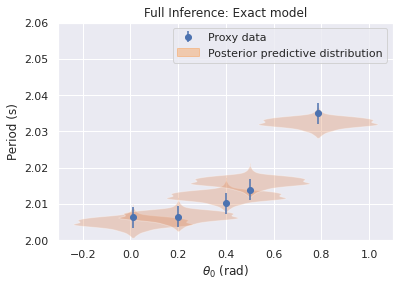

In [45]:
plt.figure()

proxy_data = plt.errorbar(measured_theta,accelerometer_means,yerr=accelerometer_errs,label='Proxy data',fmt='o')
plt.violinplot([np.array(periods_post_pex)[:,i] for i in range(len(measured_theta))],np.array(measured_theta),showmeans=False, showextrema=False, showmedians=False)
post_patch = mpatches.Patch(color='tab:orange', alpha=0.3, label='Posterior predictive distribution')

plt.legend(handles=[proxy_data,post_patch])
plt.xlabel(r"$\theta_0$ (rad)")
plt.ylabel(r"Period (s)")
plt.title(r"Full Inference: Exact model")
plt.ylim(2.0,2.06)
plt.savefig('inference_ex_predictive.png',dpi=600)
plt.show()

What we very happily see here is that our inference has worked yet again! We see that the posterior predictive samples are very close to the data and exhibit the behavior we expected. We can also see that the data doesn't line up exactly with the posterior predictive distribution, so there is potentially some room to improve the model.

## Homework: Exploring Gaussian Processes

Previously we performed direct inference. Let us now set that aside and use Gaussian Processes to emulate our model. To do this, we will use a latin hypercube algorithm from R to select our design points. We will then do our model calculations at each design point and use this data to train a Gaussian Process Emulator.

We intentionally choose the latin hypercube to evenly sample our 99% confidence regions as defined in our principled priors. This means we expect decent coverage in this region. From our direct inference, we know of course that we could sample more heavily elsewhere, but doing so would be against the spirit of the study.

#### Theory: Latin Hypercube Sampling and Gaussian Process Emulators

Before we begin, it is useful to leave some notes behind on Latin Hypercube sampling and Gaussian Processes. 

Latin Hypercube sampling (LHS) is a method of sampling to maximally cover a space with the minimal number of points. The way this happens is that a $d$ dimensional space is divided into $n$ evenly spaced regions. Samples are then taken so that a representative sample of each dimension is taken while covering the space.

There are some options in Python for performing LHS. [PyDOE](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube) is one such example and the documentation for it shows it well.

**Homework Exercise 1**: Generate a latin hypercube with PyDOE in 2, 3, 4, and 5 dimensions. Plot 2D scatter plots of the hypercubes (these will be projections when the hypercube is in 3+ dimensions). Use different criteria to generate the hypercubes. Typically, maximin is used for studies. Why is that?

Gaussian Processes (GP) are a family of statistical process. These are stochastic processes such that every finite collection has a multivariate normal distribution. They are a machine learning method that uses a kernel to calculate the similarity between points and produce not only a prediction, but also an uncertainty estimate. As a result, we can train GPs on noisy data and be able to make predictions with quantified uncertainty. This uncertainty is also tuned such that it is large in regions far from training points and similar to the data in regions well-sampled in the design space.

Different kernels are available and have different performance benefits for different problems. However, the key feature truly is the uncertainty estimation. While other interpolation techniques produce a prediction, the uncertainty is difficult to quantify whereas in this case we can robustly account of emulator uncertainty in addition to simply the model uncertainty.

Different packages are available for use in Gaussian Process emulation. Examples include `GPy` and `sklearn.gaussian_process` among others. We will use the packages we intend to use in production, which are the tools in `scikit-learn`. This is also a useful exercise, as `sklearn` is a common package in industry.

**Homework Exercise 2**: Explore Gaussian Processes in [this demo](http://www.tmpl.fi/gp/) to get a feel for how they work. Try different kernels, adding data points, and various visualization options. Think about what this means for a single draw of a GP: how good is a 1$\sigma$ uncertainty?

**Homework Exercise 3**: Read about and explore Gaussian processes in [this article](https://distill.pub/2019/visual-exploration-gaussian-processes/). Make sure to use all the interactive graphics to get a sense of how these are put together. This should give you some more intuition on Gaussian Processes before you use them in the next two sessions.

**Homework Exercise 4 - Preparation for tomorrow's session**: Review and run [this notebook](https://github.com/derekeverett/simple_bayes_with_GP/blob/ae0adaacc29b90f6b09255f2a2117a577aedd387/Infer_Shear_Viscosity_from_Flow.ipynb) on a simple Bayesian inference using Gaussian Processes. It should run out of the box and will be a preview of what you see tomorrow.

**Homework Project**: Using the notebook linked in Exercise 4 and a 1-D latin hypercube (or some evenly-spaced points), you have everything you need to train a Gaussian Process and use it as the model in the inference. This is a little more involved of an exercise, but for those of you willing to get your hands dirty in the code, this will let you explore the impact of increasing the number of training points on the precision of the final inference.

# Bonus topic 1: Comparing the posterior and the prior

Now we want to visualize what we have learned. The way we do this is by first plotting the prior and the posterior together. We then introduce and calculate the KL Distance/Divergence to quantify the difference in these distributions.

In [46]:
shape_chain_ex = inference_ex_chain.shape

In [47]:
ndraws=500

prior_draws_L=prior_g.rvs(size=ndraws)

prior_draws_closure = [[prior_draws_L[i],0] for i in range(len(prior_draws_L))]

prior_predictive_exact = np.array([model_ex_thetalist(draw[0],closure_displacements,draw[1])\
                                   for draw in prior_draws_closure])

In [48]:
posterior_samples = pd.DataFrame(inference_ex_chain,columns=["g"])
posterior_samples["Type"] = np.array(["Posterior" for x in range(shape_chain_ex[0])])

prior_samples_df = pd.DataFrame(np.array([[row[0] for row in prior_draws]]).T,
                                columns=["g"])
prior_samples_df["Type"] = np.array(["Prior" for x in range(prior_samples_df.shape[0])])

prior_and_posterior_samples = pd.concat([posterior_samples,prior_samples_df], ignore_index=True)

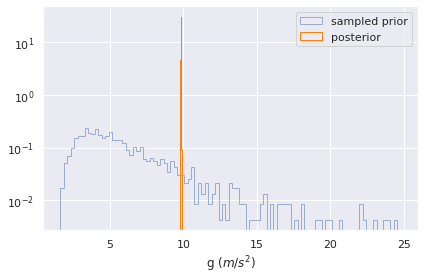

In [49]:
fig = plt.figure()
posterior_Lbins = np.linspace(9.75,9.87,50)
prior_Lbins = np.linspace(1.625,24.79,100)
plt.hist(prior_samples_df['g'], prior_Lbins, density=True, alpha=0.5, 
         label='sampled prior',log=True,histtype='step')
plt.hist(posterior_samples['g'], posterior_Lbins, density=True, alpha=1, 
         label='posterior',color='tab:orange',log=True,histtype='step')

plt.legend()
plt.xlabel(r'g ($m/s^2$)')
plt.tight_layout()
plt.savefig('prior_vs_posterior_hist.pdf',dpi=600)
plt.show()

Let's make this quantitative by calculating the statistical distance between the distributions.

#### Calculating the statistical distance between the prior and posterior

We want to have an idea of how far we've gone or how much we've learned by performing this costly inference procedure. We'll start by reproducing a decent amount of [this tutorial](https://machinelearningmastery.com/divergence-between-probability-distributions/). We'll start by defining statistical distance, what it means, and how to calculate it. I'll then define a function to do it for us and calculate the KL Divergence between our prior and both of our posteriors.

Statistical distance or divergence is a way to quantify the difference between two statistical distributions. In the case of statistical divergence, we can quantify the concept of information gain. Statistical distance measures are a little trickier to interpet, so we'll stick to divergences.

A key feature of divergence measures is that they are asymmetric. We can see this in the case of the Kullback–Leibler (KL) divergence, which we will use here. This is a useful quantity for several reasons: In Bayesian use cases, the KL divergence between the prior and the posterior can be used to quantify the amount of knowledge we gain from our inference. However, if working with complex distributions and approximations to them, we can also calculate how well our approximation matches the true distribution. For example, if we are using approximate methods to calculate the posterior and we know the true posterior, we can use the KL Divergence to quantiy how close our approximation is to the truth. If we have multiple iterations of a sequential sampling/active learning algorithm, we can also use the KL Divergence to quantify how rapidly we approach the true distribution.

The KL divergence for distributions $P$ and $Q$ of a continuous random variable is defined as

$$
KL (P || Q) = \int P(x) \log \left( \frac{P(x)}{Q(x)}\right) dx
$$

and for distributions $P$ and $Q$ of a discrete random variable, the KL divergence is defined via a Riemann sum

$$
KL (P || Q) = \sum_{i} P(x_i) \log \left( \frac{P(x_i)}{Q(x_i)}\right) \Delta x_i.
$$

As in all cases of Riemann sums, when $\Delta x_i \rightarrow 0$, the two definitions become equivalent although as the number of samples is also finite, the condition $n_{samples} \rightarrow \infty$ must be simultaneously approached to recover the integral expression. This quantifies $P$'s divergence from $Q$. We choose the prescription $n_{bins} = 2*\sqrt[3]{n_{samples}}$.

Usually, $P$ represents data or the precisely measured distribution while $Q$ represents the model. Or, if one likes, $P$ can be the posterior and $Q$ the prior as the prior is our less-informed understanding.

In [50]:
def KL_divergence(h1, h0, dx):
    """ 
    h0, h1 are histograms
    dx is the bin width, which we assume is uniform
    
    Return the information gain of pdf x1 w.r.t. x0, approximated by
    riemann sum over histograms of each pdf. Assumes that distributions have the exact same bins
    and that bin widths are uniform! 
    """
    #get nonzero values of posterior, the logarithm is ill-defined for bins with zero
    
    nonzero_idx = [x!=0 for x in h1] # get indices for nonzero bins
    h1 = h1[ nonzero_idx ] # filter
    h0 = h0[ nonzero_idx ]
    
    nonzero_idx = [x!=0 for x in h0] # get indices for nonzero bins
    h1 = h1[ nonzero_idx ] # filter
    h0 = h0[ nonzero_idx ]

    KLdiv = np.sum( h1 * np.log2(h1/h0) ) * np.prod(dx) # calculate the KL divergence
    
    return KLdiv

In [51]:
n_of_bins = 2*int(len(prior_samples_df['g'])**(1/3))
gbins = np.linspace(1.625,24.79,n_of_bins)
dg = gbins[1]-gbins[0]
g_prior_hist = np.histogram(prior_samples_df['g'],gbins,density=True)
g_post_hist = np.histogram(posterior_samples['g'],gbins,density=True)
g_KL_div = KL_divergence(g_post_hist[0],g_prior_hist[0],dg)

In [52]:
print(f'KL(g_prior || g_posterior) = {g_KL_div} bits')

KL(g_prior || g_posterior) = 4.586494670312792 bits


Now let's do a sanity check: does this line up with our expectations?

Yes! We see from the KL Divergence that we gain a lot of information on the gravitational acceleration, which matches what we expected from directly comparing the distributions.

# Bonus topic 2: Model Selection and Bayes Factors

Increasingly, model selection and model mixing are seen in research work. If we had another model, we could demonstrate this exactly, but due to time constraints, this isn't possible. However, it is important to help publicize these tools in the field. I give a brief overview of Bayes factors and Bayesian model selection here.

Let's start off by restating Bayes' theorem.

$$
p(\theta | D) = \frac{p(D | \theta) p(\theta)}{p(D)}
$$

which is often simplified to 

$$
p(\theta | D) \propto p(D | \theta) p(\theta).
$$

The conventional wisdom behind this is that $p(D)$ is an overall normalization factor, so it is unimportant for drawing contours, credible regions, etc. However, we can compare the probability of the data (often called the Bayes evidence) between two models and use this to determine which is preferred.

The simplest way to calculate the evidence is through a function already built into the `ptemcee` package. The reason this computation is easier in `ptemcee` is that it uses thermodynamic integration which is available since the method is thermodynamically defined via parallel tempering.

In [55]:
logZ_ex, dlogZ_ex = ptsampler_exinf.log_evidence_estimate()

NameError: name 'ptsampler_exinf' is not defined

In [ ]:
print("Exact Model Log Evidence: {} +/- {}".format(logZ_ex, dlogZ_ex))

And now we can finally calculate the Bayes factor.

Quoting the well-known paper by Trotta:
[Bayes in the sky: Bayesian inference and model selection in cosmology](https://arxiv.org/abs/0803.4089) we can quantify an empirical scale for evaluating the strength of evidence when comparing two models in Table 1 of "Bayes in the Sky". Two alternative scales are provided [on the Wikipedia page on Bayes factors](https://en.wikipedia.org/wiki/Bayes_factor).

Here, the ratio of the evidences of model $M_0$ and $M_1$ is given by,
\begin{equation}
 \label{eq:Bayes_factor}
 B_{01} = \frac{p(\mathrm{data} | M_0)}{p(\mathrm{data} | M_1)} \; ,
\end{equation}
which is also called _Bayes factor_. That means $|\ln B_{01}| \equiv |\ln p(\mathrm{data} | M_0) - \ln p(\mathrm{data} | M_1)|$ is the relevant quantity for estimating the strength of evidence of the two models (see first and last column of the table).